In [10]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import talib

sns.set_theme(style="darkgrid")

%load_ext autoreload
%autoreload 2

In [76]:
df = yf.download("SBIN.NS", start="2020-01-01", end="2023-01-01", interval="1d", progress=False)
# add a column for the date
df['Date'] = df.index
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')

df.reset_index(inplace=True, drop=True)
df

,Open,High,Low,Close,Adj Close,Volume,Date
0,334.700012,335.950012,332.149994,334.450012,326.298218,17379320,2020-01-01
1,334.500000,339.850006,333.350006,339.299988,331.029968,20324236,2020-01-02
2,337.950012,337.950012,332.000000,333.700012,325.566467,21853208,2020-01-03
3,331.700012,331.700012,317.700012,319.000000,311.224762,35645325,2020-01-06
4,324.450012,327.000000,315.399994,318.399994,310.639374,50966826,2020-01-07
...,...,...,...,...,...,...,...
742,574.000000,601.700012,570.700012,597.099976,597.099976,13201587,2022-12-26
743,600.400024,603.099976,593.299988,601.900024,601.900024,9638618,2022-12-27
744,600.900024,607.000000,598.549988,601.049988,601.049988,7988631,2022-12-28
745,600.000000,618.000000,597.150024,611.799988,611.799988,20130392,2022-12-29


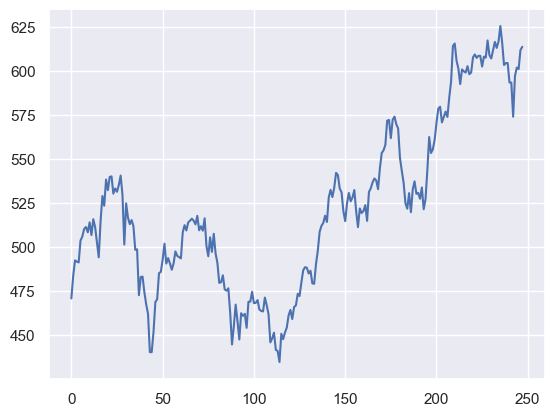

In [68]:
plt.plot(df['Close'])

In [99]:
def is_consolidating(df, window = 15, percentage = 2):
    recent_candlesticks = df[-window:]
    max_close = recent_candlesticks['Close'].max()
    min_close = recent_candlesticks['Close'].min()
    threshold = 1 - (percentage / 100)
    if min_close > (max_close * threshold):
        return True
    return False

def is_breaking_out(df, window = 15, percentage = 0.02):
    last_close = df[-1:]['Close'].values[0]
    recent_closes = df[-window:-1]['Close']
    if is_consolidating(df, window, percentage):
        if last_close > recent_closes.max():
            return True
    return False

In [141]:
# iterate over the dataframe, and check if the stock is consolidating

def check_consolidation(df, window=15, percentage = 5):
    consolidating_periods = []
    i = 0
    while i < len(df) - window:
        if is_consolidating(df.iloc[i:i + window], percentage=percentage):
            consolidating_periods.append(i)
            i += 15
        i += 1

    return consolidating_periods

def check_breakout(df, window=15, percentage = 5):
    breakout_periods = []
    i = 0
    while i < len(df) - window:
        if is_breaking_out(df.iloc[i:i + window], percentage=percentage):
            breakout_periods.append(i + window - 1)
            i += 15
        i += 1

    return breakout_periods

In [142]:
consolidating_periods = check_consolidation(df)
print(consolidating_periods)

[26, 348, 364, 380, 501, 556, 592, 646, 680, 706, 722]


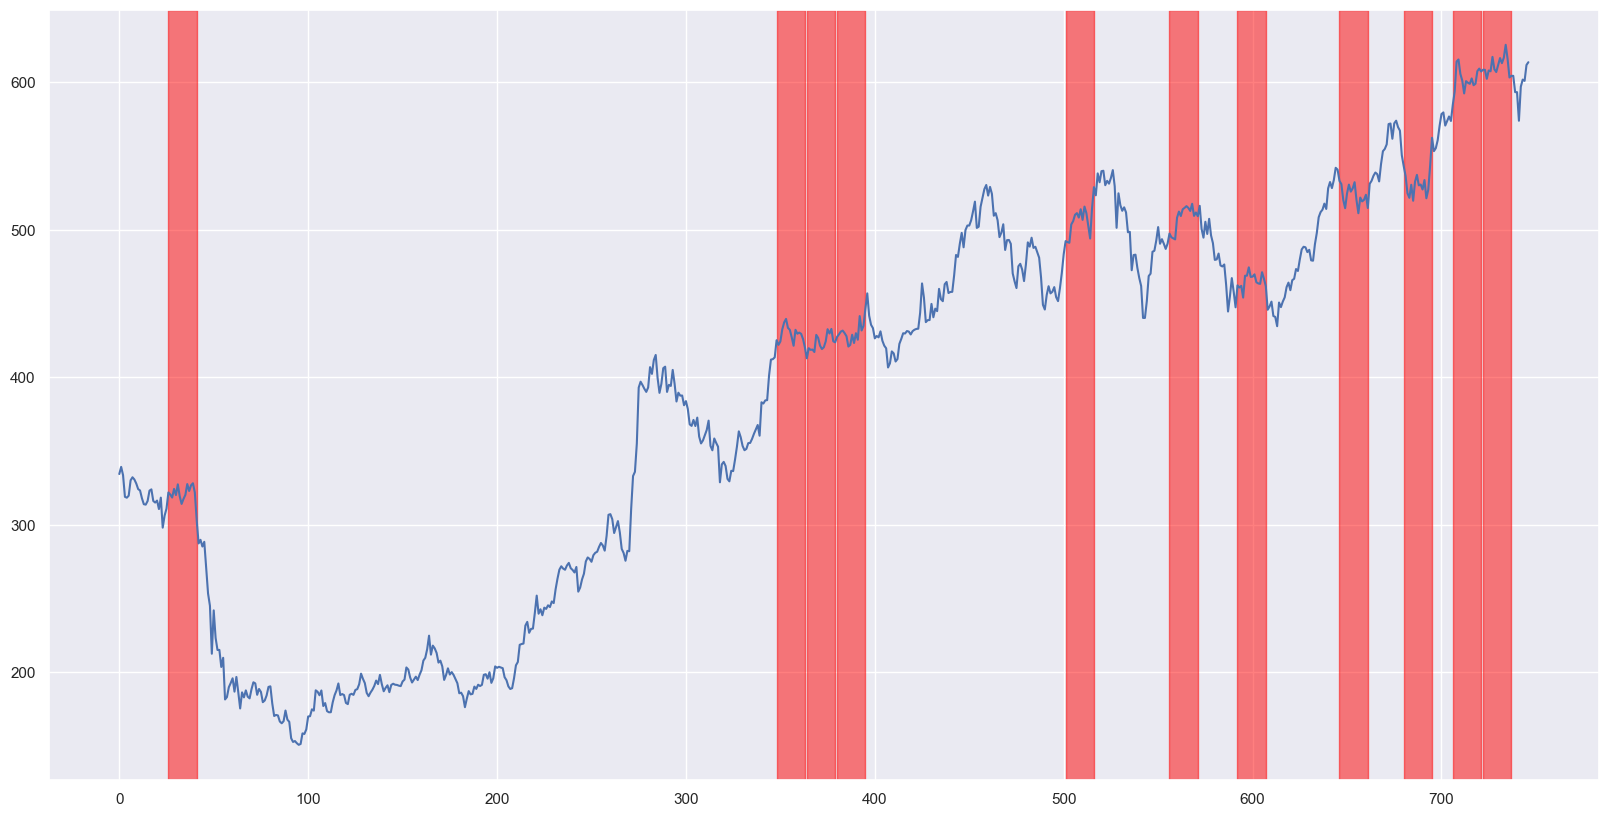

In [143]:
# mark the consolidation periods on the graph
plt.figure(figsize=(20,10))
plt.plot(df['Close'])
# plot a horizontal rectangle of width 15 for each consolidation period
for p in consolidating_periods:
    plt.axvspan(p, p+15, color='red', alpha=0.5)

In [144]:
def graph_candlestick(df, consolidating_periods):
    fig = go.Figure(data=[go.Candlestick(x=df['Date'], open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'])])

    # mark the consolidation periods on the graph
    for p in consolidating_periods:
        fig.add_shape(type="rect",
            xref="x", yref="paper",
            x0=df.iloc[p]['Date'], y0=0, x1=df.iloc[p + 15]['Date'], y1=1,
            line=dict(
                color="Red",
                width=1,
            ),
            fillcolor="Red",
            opacity=0.2,
            layer="below"
        )
    return fig

graph_candlestick(df, consolidating_periods).show()

In [145]:
breakout_periods = check_breakout(df)
breakout_periods

[375, 392, 663, 694, 727]

In [146]:
fig = graph_candlestick(df, consolidating_periods)

# mark the breakout periods as a scatter on the graph
fig.add_trace(go.Scatter(x=df.iloc[breakout_periods]['Date'], y=df.iloc[breakout_periods]['Close'], mode='markers', name='breakout', 
                         marker = dict(size = 5, color = 'blue', line=dict(width=0.5)))
            )
fig

In [114]:
upper, middle, lower = talib.BBANDS(df['Close'], 20, 2, 2)

In [122]:
# add the bollinger bands to the graph
fig = go.Figure(data=[go.Candlestick(x=df['Date'], open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'])])
fig.add_trace(go.Scatter(x=df['Date'], y=upper, mode='lines', name='upper', line=dict(color='gray', width=1)))
fig.add_trace(go.Scatter(x=df['Date'], y=middle, mode='lines', name='middle', line=dict(color='gray', width=1)))
fig.add_trace(go.Scatter(x=df['Date'], y=lower, mode='lines', name='lower', line=dict(color='gray', width=1)))

# color the area between the bollinger bands
fig.add_trace(go.Scatter(x=df['Date'], y=upper, fill='tonexty', mode='none', name='upper', fillcolor='rgba(0,176,246,0.2)'))

# add title and axis labels
fig.update_layout(title='Bollinger Bands', yaxis_title='Price')

fig

In [125]:
# get super trend values
def super_trend(df, period=7, multiplier=3):
    df['atr'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=period)
    upperband = ((df['High'] + df['Low']) / 2) + (multiplier * df['atr'])
    lowerband = ((df['High'] + df['Low']) / 2) - (multiplier * df['atr'])

    return upperband, lowerband

upperband, lowerband = super_trend(df)

In [129]:
fig = go.Figure(data=[go.Candlestick(x=df['Date'], open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'])])

fig.add_trace(go.Scatter(x=df['Date'], y=upperband, mode='lines', name='upper', line=dict(color='gray', width=1)))
fig.add_trace(go.Scatter(x=df['Date'], y=lowerband, mode='lines', name='lower', line=dict(color='gray', width=1)))

# color the area between the bands
fig.add_trace(go.Scatter(x=df['Date'], y=upperband, fill='tonexty', mode='none', name='upper', fillcolor='rgba(0,176,246,0.2)'))

# add title and axis labels
fig.update_layout(title='Super Trend', yaxis_title='Price')

In [136]:
# check for buy and sell signals
def get_signals(df, upperband, lowerband):
    buy_signals = []
    sell_signals = []
    for i in range(1, len(df)):
        if df['Close'][i] > upperband[i-1]:
            buy_signals.append(i)
        elif df['Close'][i] < lowerband[i-1]:
            sell_signals.append(i)
    return buy_signals, sell_signals

buy_signals, sell_signals = get_signals(df, upperband, lowerband)

In [137]:
fig = go.Figure(data=[go.Candlestick(x=df['Date'], open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'])])

fig.add_trace(go.Scatter(x=df['Date'], y=upperband, mode='lines', name='upper', line=dict(color='gray', width=1)))
fig.add_trace(go.Scatter(x=df['Date'], y=lowerband, mode='lines', name='lower', line=dict(color='gray', width=1)))

# color the area between the bands
fig.add_trace(go.Scatter(x=df['Date'], y=upperband, fill='tonexty', mode='none', name='upper', fillcolor='rgba(0,176,246,0.2)'))

# add buy and sell signals
fig.add_trace(go.Scatter(x=df.iloc[buy_signals]['Date'], y=df.iloc[buy_signals]['Close'], mode='markers', name='buy'))
fig.add_trace(go.Scatter(x=df.iloc[sell_signals]['Date'], y=df.iloc[sell_signals]['Close'], mode='markers', name='sell'))

# add title and axis labels
fig.update_layout(title='Super Trend (with buy and sell signals)', yaxis_title='Price')